In [98]:
import pandas as pd
import os
data = ['dataSet_1','dataSet_2','dataSet_3','function_smoke_test']
requests = pd.read_json(os.path.join(data[3],'requests'),lines=True)
metas = pd.read_json(os.path.join(data[3],'metas'),lines=True)

In [99]:
requests['endTime'] = requests['startTime'] + requests['durationsInMs']
start_time = requests['startTime'].min()
requests = requests.sort_values(by=['metaKey', 'startTime'])
def calculate_idle_time(group):
    group = group.sort_values(by='endTime')
    group['next_startTime'] = group['startTime'].shift(-1)
    group['idle_time'] = group['next_startTime'] - group['endTime']
    return group

requests = requests.groupby('metaKey').apply(calculate_idle_time)
requests['idle_time'] = requests.apply(lambda row:row['startTime']-start_time if pd.isnull(row['idle_time']) else row['idle_time'],axis=1)
requests.loc[requests['idle_time'] < 0, 'idle_time'] = 0
requests['idle_time_in_sec'] = requests['idle_time'] /1000

In [100]:
# 将每个metaKey的idle_time_in_sec求直方图\
import numpy as np
def calculate_cv(series):
    hist, bin_edges = np.histogram(series, bins=100)
    hist_mean = hist.mean()
    hist_std = hist.std()
    cv = hist_std / hist_mean
    return cv 
requests.groupby(level='metaKey')['idle_time'].apply(calculate_cv)

metaKey
02f14aa682a90f8f6501d44328eae3fa37e65a7e    9.949874
030707aacf589606b1160912bdf4396b2d252915    7.000000
034ab3cfed64d7e57f4bd50e0094ca01bdcd406b    9.949874
0441a8f627e4cec7886d5a9dde46be3f836c4d1c    9.949874
05e691f4c1cc529ffb86d455105c7d9be246adab    9.949874
                                              ...   
f102b8535b7743fe81e1df421ee930c1d35a9266    9.149985
f21f53919d89a15bc8ef54ab26e7a95a89ca2c28    9.949874
f471737eded9df47aacaeb8ab01554c69070d330    9.949874
f7a809aa1ac055ba46289697ef2cbddf79ff81f5    9.949874
fdeaede1e61cad560a0a9843e378f1708db158c2    9.949874
Name: idle_time, Length: 127, dtype: float64

In [101]:
idle_time_stats = requests.groupby(level='metaKey')['idle_time'].describe()
idle_time_stats_filtered = idle_time_stats[idle_time_stats['count'] > 10]
metas = metas.rename(columns={'key': 'metaKey'})
merged = metas.merge(idle_time_stats_filtered, on='metaKey', how='inner')



filtered = merged[['metaKey','25%','50%','75%']]
filtered = filtered.merge(requests.groupby(level='metaKey')['idle_time'].apply(calculate_cv),on='metaKey',how='inner')
# filtered['cv'] = requests.groupby(level='metaKey')['idle_time_in_sec'].apply(calculate_cv)
filtered = filtered.rename(columns={'idle_time':'cv'})
filtered
merged
# write to csv,mode:append
# filtered.to_csv('idle_time_stats.csv',mode='a',header=False,index=False)

,metaKey,runtime,memoryInMb,timeoutInSecs,initDurationInMs,count,mean,std,min,25%,50%,75%,max
0,59604e0de19592edd848d362fe515f9d88458617,custom,8192,60,3085,13.0,892.923077,3047.358678,3.0,13.00,29.0,81.00,11034.0
1,a4be92b8b8051a178b2c5520bf9cb9cc96c6ae3d,container,4096,60,15481,38.0,323.657895,1811.429259,0.0,6.25,15.0,39.50,11193.0
2,f102b8535b7743fe81e1df421ee930c1d35a9266,php,256,60,147,12.0,881.166667,3049.932394,0.0,0.00,0.0,0.00,10566.0
3,f019399e26b2618681f4668ece7038968f99ebeb,container,1024,7200,4950,101.0,116.386139,1110.614442,0.0,0.00,1.0,9.00,11167.0
4,36bf9a5965e2bc6eb21d749b35f69500071adef2,custom,256,120,1655,110.0,101.609091,1063.570342,0.0,0.00,0.0,0.00,11155.0
5,bfd79f355fddc01f12ef176dc5e08590574bb3c8,php,128,60,143,152.0,73.585526,907.223298,0.0,0.00,0.0,0.00,11185.0
6,70730cd24bb415306f30eaedb3c3838d2ebebc0c,nodejs,128,60,287,11.0,1101.090909,3359.839087,1.0,22.50,41.0,171.50,11226.0
7,7ab4926bf7de91ed1b8d85f52b32ad4e206d43e6,php,256,90,97,35.0,298.971429,1744.281640,0.0,0.00,0.0,0.00,10323.0
8,3e883b5a65dc5381bccd603adc123405c85115a1,java,512,60,5139,12.0,907.666667,3063.600892,0.0,0.00,0.0,40.50,10635.0
9,7afe8d0bd7e6dae9b6e980bdc5aa627a570eb02b,custom,3072,60,7402,34.0,348.088235,1923.587894,0.0,0.00,12.0,30.75,11234.0


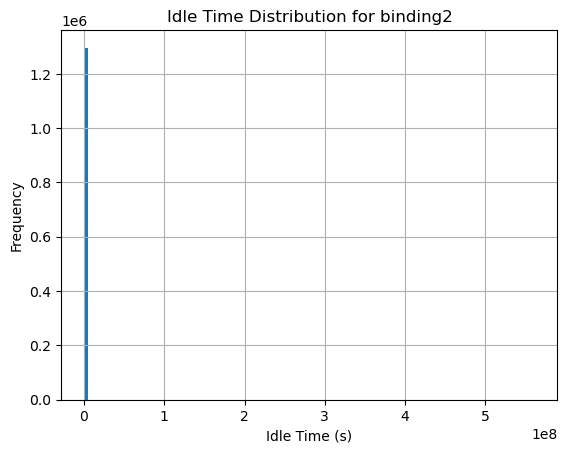

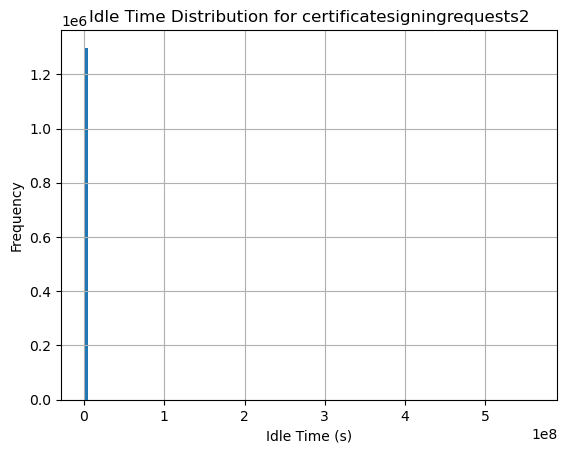

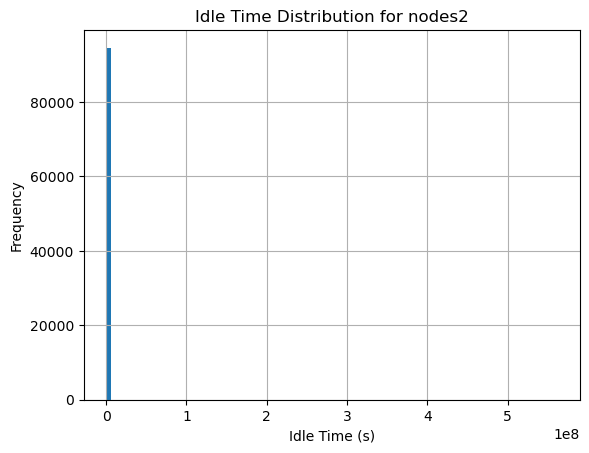

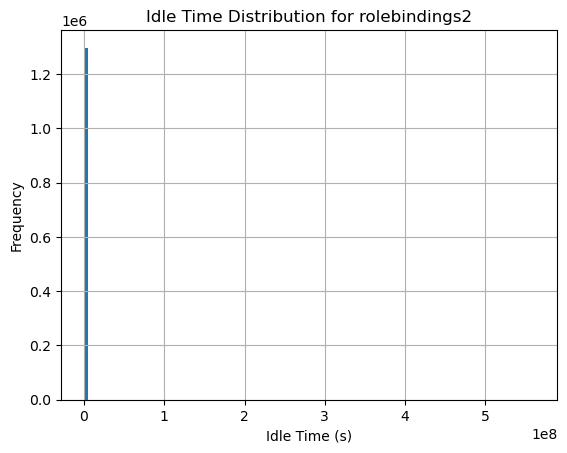

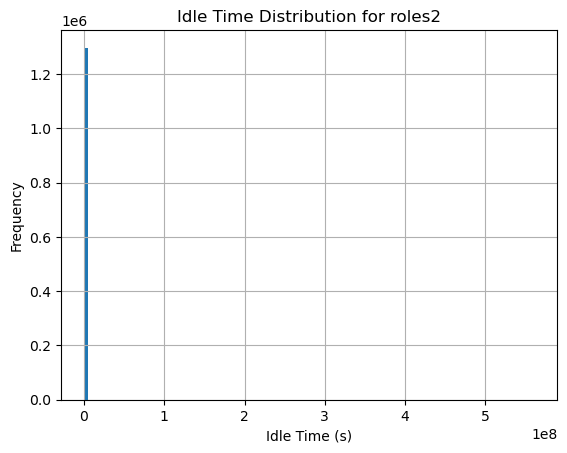

In [95]:
import matplotlib.pyplot as plt

# 获取所有唯一的metaKeys
meta_keys = requests['metaKey'].unique()

# 为每个metaKey创建一个直方图
for key in meta_keys:
    # 过滤掉请求次数小于10的metaKey
    if idle_time_stats.loc[key]['count'] < 10:
        continue
    requests[requests['metaKey'] == key]['idle_time'].hist(bins=100)
    
    plt.title(f'Idle Time Distribution for {key}')
    plt.xlabel('Idle Time (s)')
    plt.ylabel('Frequency')
    
    plt.show()